# REPLUG: Retrieval-Augmented Language Models




REPLUG (Retrieval Plugin) enhances large language models (LLMs) by retrieving relevant external documents to improve prediction accuracy. This innovative framework treats the language model as a fixed "black box," simply prepending retrieved information to the input. This flexible design allows REPLUG to work seamlessly with existing models without requiring modifications, effectively integrating external knowledge to reduce errors and hallucinations. Additionally, the retrieval component can be fine-tuned using feedback from the model, aligning better with the model’s needs and expanding its niche knowledge.



## Key Features of REPLUG



- **Black Box Approach**: Treats the language model as a fixed entity, allowing for straightforward integration without altering the model's internal parameters.

- **Prepending Retrieved Information**: Enhances the input by adding relevant documents retrieved from external sources, improving context and accuracy in predictions.

- **Flexible Design**: Works with various existing language models, making it adaptable and easy to implement across different applications.

- **Fine-Tuning Capability**: The retrieval component can be fine-tuned based on feedback from the language model, optimizing its performance to better meet specific needs.



## How REPLUG Works



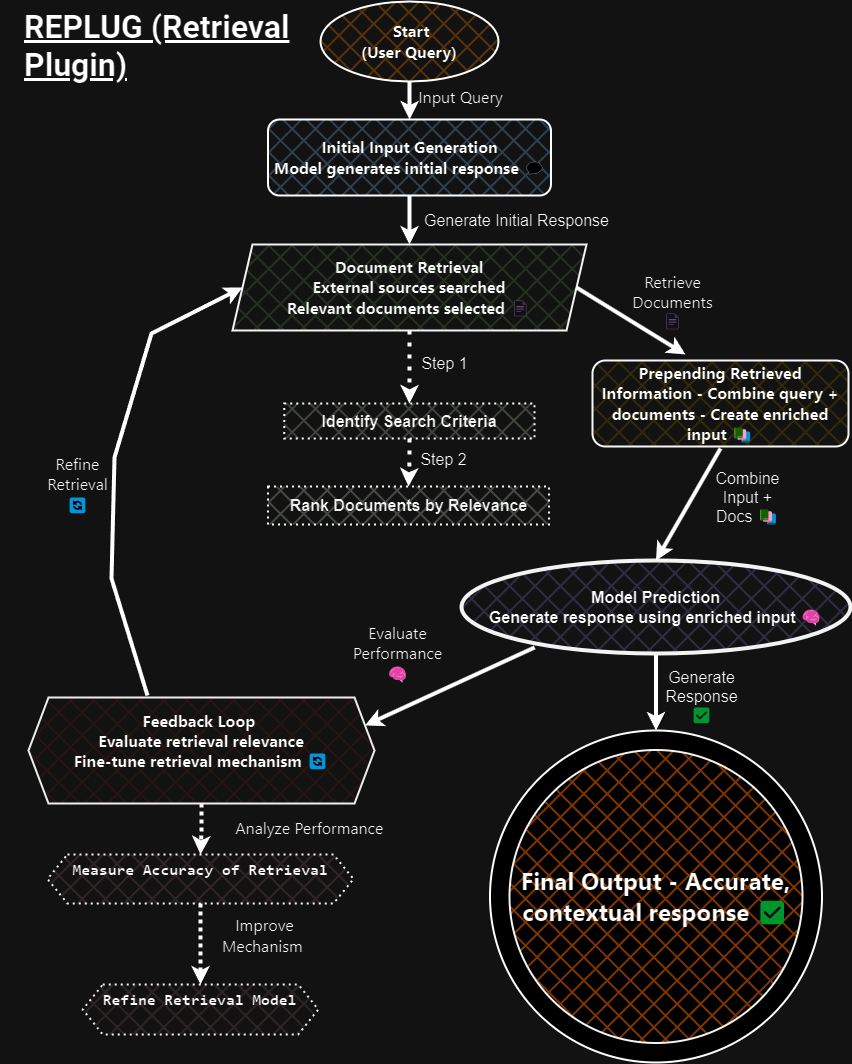

1. **Initial Input Generation**: When a query is received, REPLUG first generates an initial response based on the internal knowledge of the language model.

2. **Document Retrieval**:
   - The system retrieves relevant documents from external sources (e.g., databases or knowledge bases) based on the initial query.
   - These documents are selected using a retrieval mechanism that ensures relevance to the task at hand.

3. **Prepending Retrieved Information**: The retrieved documents are prepended to the original input, creating a new input that combines both the user query and relevant contextual information.

4. **Model Prediction**: The modified input is then fed into the language model, which generates a response based on this enriched context.

5. **Feedback Loop for Fine-Tuning**:
   - The performance of the retrieval component can be evaluated based on how well it supports accurate predictions.
   - Feedback from the language model is used to fine-tune the retrieval mechanism, improving its ability to select relevant documents in future queries.


In [ ]:
!pip install pypdf2 groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
import os
import requests
from PyPDF2 import PdfReader
from groq import Groq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Step 1: Initialize the Groq client
client = Groq(api_key="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")

In [ ]:
# Step 2: Download and process the PDF document
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper on Masked Language Models
pdf_path = "BERT_paper.pdf"

In [ ]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [ ]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [ ]:
# Step 3: Define the query
query = "What is LTR?"
evaluation_dataset = [
    {"query": query, "expected_output": "Information about LTR (Learning to Rank)"}
]

In [ ]:
# Step 4: Chunk the document for processing
chunks = [text[i:i + 1000] for i in range(0, len(text), 1000)]  # Divide document into manageable chunks
vectorizer = TfidfVectorizer()
chunk_embeddings = vectorizer.fit_transform(chunks)
query_embedding = vectorizer.transform([query])

In [ ]:
# Step 5: Retrieve relevant chunks using cosine similarity
similarities = cosine_similarity(query_embedding, chunk_embeddings).flatten()
top_k = 5  # Retrieve the top 5 most relevant chunks
retrieved_chunk_indices = similarities.argsort()[-top_k:][::-1]
retrieved_chunks = [chunks[i] for i in retrieved_chunk_indices]

In [ ]:
print(f"Top retrieved chunks for query '{query}':\n")
for idx, chunk in enumerate(retrieved_chunks, start=1):
    print(f"Chunk {idx}: {chunk[:200]}...\n")  # Display first 200 characters of each chunk

Top retrieved chunks for query 'What is LTR?':

Chunk 1: ch
is trained using a standard Left-to-Right (LTR)
LM, rather than an MLM. The left-only constraint
was also applied at ﬁne-tuning, because removing
it introduced a pre-train/ﬁne-tune mismatch that
de...

Chunk 2: LI MRPC SST-2 SQuAD
(Acc) (Acc) (Acc) (Acc) (F1)
BERT BASE 84.4 88.4 86.7 92.7 88.5
No NSP 83.9 84.9 86.5 92.6 87.9
LTR & No NSP 82.1 84.3 77.5 92.1 77.8
+ BiLSTM 82.1 84.1 75.7 91.6 84.9
Table 5: Abl...

Chunk 3: of Training Steps
Figure 5 presents MNLI Dev accuracy after ﬁne-
tuning from a checkpoint that has been pre-trained
forksteps. This allows us to answer the following
questions:
1. Question: Does BERT ...

Chunk 4: gthening the LTR system, we added
a randomly initialized BiLSTM on top. This does
signiﬁcantly improve results on SQuAD, but theresults are still far worse than those of the pre-
trained bidirectional...

Chunk 5:  need to be learned from scratch.
Among the tasks, (a) and (b) are sequence-level
tasks

In [ ]:
# Step 6: REPLUG Process - Prepending retrieved information to the original query and passing it to Groq
module_results = []
for chunk in retrieved_chunks:
    try:
        # The query and the relevant chunk are prepended to create a new input
        combined_input = f"Query: {query}\nRelevant information: {chunk}"

        # Send the combined input to the Groq API for generating the final answer
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a highly knowledgeable assistant."},
                {"role": "user", "content": combined_input},
            ],
            model="llama3-8b-8192",  # Model selection
        )

        answer = response.choices[0].message.content
        module_results.append({"chunk": chunk[:200], "answer": answer})  # Store chunk and answer
        print(f"Generated answer: {answer}")

    except Exception as e:
        print(f"Error generating answer: {e}")

Generated answer: Based on the provided text, LTR stands for Left-to-Right, which is a type of language model (LM) used in language processing tasks. In this specific context, the text is discussing the training of a language model using a Left-to-Right language model (LTR LM) versus a Masked Language Model (MLM).

In a Left-to-Right language model, the model is trained to predict the next word or character in a sequence, given the previous words or characters. This approach assumes that the model will only predict words or characters from left to right, without considering the right-side context.

In comparison, a Masked Language Model (MLM) is trained to predict the missing word or character in a sequence, where some of the input words or characters are randomly replaced with a special token. This approach allows the model to learn bidirectional context, meaning it can consider both the left and right sides of a word or character when making predictions.

In the given text, the autho

In [ ]:
# Step 7: Find the best result
best_result = max(module_results, key=lambda x: len(x["answer"]))  # Select result with the longest answer
print("\nBest result based on module evaluation:")
print(f"Chunk: {best_result['chunk']}\nAnswer: {best_result['answer']}")


Best result based on module evaluation:
Chunk: ch
is trained using a standard Left-to-Right (LTR)
LM, rather than an MLM. The left-only constraint
was also applied at ﬁne-tuning, because removing
it introduced a pre-train/ﬁne-tune mismatch that
de
Answer: Based on the provided text, LTR stands for Left-to-Right, which is a type of language model (LM) used in language processing tasks. In this specific context, the text is discussing the training of a language model using a Left-to-Right language model (LTR LM) versus a Masked Language Model (MLM).

In a Left-to-Right language model, the model is trained to predict the next word or character in a sequence, given the previous words or characters. This approach assumes that the model will only predict words or characters from left to right, without considering the right-side context.

In comparison, a Masked Language Model (MLM) is trained to predict the missing word or character in a sequence, where some of the input words or characters

## Code Explanation

## Groq Client Initialization
A client instance is created to interact with the Groq API by providing the API key. The client will be used to send queries and receive responses from the API.

## Downloading and Processing the PDF Document
The code fetches the PDF of the BERT paper (or any other provided URL) using the requests library and saves it locally. The PDF file is then read using PyPDF2 to extract the text content from each page.

## Query Definition
A query, in this case, "What is LTR?" is defined. This query will be used to search for relevant information in the document.

## Chunking the Document
The document's extracted text is divided into chunks of 1000 characters for easier processing. This makes it manageable to search through large documents without overwhelming the model.

## Text Vectorization
TfidfVectorizer is used to convert the chunks of text and the query into numerical representations (embeddings) that can be compared for similarity. The query is transformed into an embedding, which will be compared to the embeddings of the document chunks.

## Document Retrieval
The cosine similarity between the query embedding and each document chunk's embedding is calculated. The top k (5 in this case) most similar chunks are retrieved based on the similarity score. These chunks are the most relevant to the query and will be used in the next steps.

## REPLUG Process
The retrieved document chunks are prepended (placed before) the original query to create a new input. This combined input now includes the user's query along with the relevant context from the retrieved chunks. This combined input is sent to the Groq API for generating a response. The model processes this enriched context to provide an accurate answer.

## Answer Generation
The Groq API generates an answer based on the query and the retrieved context (chunks). The response is captured, and the generated answer is displayed alongside the chunk of text it was based on.

## Feedback Loop
The module results (i.e., generated answers) are stored, and the system can use this information to refine or adjust its approach in future iterations. This could involve adjusting which chunks are retrieved or how the response is structured.

## Final Answer Selection
The answer with the most comprehensive or relevant response is selected as the best result, based on criteria such as the length of the answer (or another measure of quality).


## Applications of REPLUG



- **Open-Domain Question Answering**: Enhances systems that require accurate answers by leveraging external knowledge effectively.

- **Content Generation**: Assists writers and content creators by providing relevant information that enriches narrative quality and factual accuracy.

- **Knowledge Management Systems**: Improves access to information by ensuring that users receive accurate and contextually relevant responses based on comprehensive data retrieval.

- **Educational Tools**: Supports learning applications by providing students with reliable information tailored to their queries.



## Advantages of REPLUG



- **Improved Prediction Accuracy**: By incorporating relevant external documents, REPLUG significantly enhances the accuracy of predictions made by LLMs.

- **Reduction of Hallucinations**: Grounding responses in factual information helps minimize instances where models generate incorrect or nonsensical outputs.

- **Efficiency in Implementation**: The ability to integrate with existing models without extensive modifications streamlines deployment and reduces development time.

- **Enhanced Performance with Fewer Examples**: REPLUG demonstrates strong performance across tasks even when trained on fewer examples, making it efficient and adaptable.



## Limitations of REPLUG



- **Dependence on Quality of Retrieved Documents**: The effectiveness of REPLUG is contingent upon the quality and relevance of the documents retrieved; poor-quality sources can lead to inaccuracies.

- **Complexity in Fine-Tuning**: While fine-tuning the retrieval component can enhance performance, it may also introduce complexity in managing multiple models and their interactions.

- **Resource Intensive**: The process of retrieving and integrating external documents may require significant computational resources, especially for large-scale applications.



## Conclusion



REPLUG represents a significant advancement in enhancing large language models through effective retrieval mechanisms. By treating LLMs as black boxes while integrating external knowledge seamlessly, it improves prediction accuracy and reduces errors associated with hallucinations. As AI continues to evolve, frameworks like REPLUG will play a crucial role in refining how language models interact with vast amounts of data, ultimately leading to more reliable and efficient applications.



Having explored REPLUG, we will now move on to MEMO RAG.